## 以靜態變數訓練Lightgbm Model (非Moving Windows)

In [1]:
import numpy as np
import pandas as pd

#2020/2/2:將rawdata的'U'全換成右手R
data_ATP=pd.read_csv(r"C:\Users\road\Desktop\NCCU\SportBigData\Tennis\ATP tennis dataset\ATP_Match_lightgbm.csv")
ATP_match_data=data_ATP[['period','rank1','rankpoint1','rank2','rankpoint2','age1','age2','turn_pro_years_1','turn_pro_years_2','hand1','hand2']]
ATP_match_result=data_ATP['result'].astype('uint8')
features=['rank1','rankpoint1','rank2','rankpoint2','age1','age2','turn_pro_years_1','turn_pro_years_2','hand1','hand2']

In [2]:
ATP_match_data.head()

,period,rank1,rankpoint1,rank2,rankpoint2,age1,age2,turn_pro_years_1,turn_pro_years_2,hand1,hand2
0,1,1,4135,112,353,29.72,21.33,14,2,R,L
1,1,47,728,77,518,23.36,23.27,6,5,R,R
2,1,27,1111,33,936,25.32,21.88,7,4,R,R
3,1,93,432,204,166,29.76,28.79,11,12,L,R
4,1,46,732,65,599,23.75,31.16,6,11,R,L


In [3]:
#2020/2/2:將rawdata的'U'全換成右手R
data_ATP_mirror=pd.read_csv(r"C:\Users\road\Desktop\NCCU\SportBigData\Tennis\ATP tennis dataset\ATP_Match_mirror_lightgbm.csv")
ATP_match_data_mirror=data_ATP_mirror[['period','rank1','rankpoint1','rank2','rankpoint2','age1','age2','turn_pro_years_1','turn_pro_years_2','hand1','hand2']]
ATP_match_result_mirror=data_ATP_mirror['result'].astype('uint8')

In [4]:
ATP_match_data_mirror.head()

,period,rank1,rankpoint1,rank2,rankpoint2,age1,age2,turn_pro_years_1,turn_pro_years_2,hand1,hand2
0,1,112,353,1,4135,21.33,29.72,2,14,L,R
1,1,77,518,47,728,23.27,23.36,5,6,R,R
2,1,33,936,27,1111,21.88,25.32,4,7,R,R
3,1,204,166,93,432,28.79,29.76,12,11,R,L
4,1,65,599,46,732,31.16,23.75,11,6,L,R


### Label Encoding

In [5]:
#隐藏警告
import warnings
warnings.filterwarnings('ignore')

#將類別變數做Label Encoding
# 慣用手 : R為1,L為0
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
ATP_match_data['hand1']=le.fit_transform(ATP_match_data.hand1)
ATP_match_data['hand2']=le.fit_transform(ATP_match_data.hand2)
ATP_match_data_mirror['hand1']=le.fit_transform(ATP_match_data_mirror.hand1)
ATP_match_data_mirror['hand2']=le.fit_transform(ATP_match_data_mirror.hand2)

### 特徵工程

In [6]:
ATP_match_data['rank_gap']=ATP_match_data.rank1-ATP_match_data.rank2
ATP_match_data['rankpoint_gap']=ATP_match_data.rankpoint1-ATP_match_data.rankpoint2
ATP_match_data['age_gap']=ATP_match_data.age1-ATP_match_data.age2
ATP_match_data['turn_pro_years_gap']=ATP_match_data.turn_pro_years_1-ATP_match_data.turn_pro_years_2


ATP_match_data_mirror['rank_gap']=ATP_match_data_mirror.rank1-ATP_match_data_mirror.rank2
ATP_match_data_mirror['rankpoint_gap']=ATP_match_data_mirror.rankpoint1-ATP_match_data_mirror.rankpoint2
ATP_match_data_mirror['age_gap']=ATP_match_data_mirror.age1-ATP_match_data_mirror.age2
ATP_match_data_mirror['turn_pro_years_gap']=ATP_match_data_mirror.turn_pro_years_1-ATP_match_data_mirror.turn_pro_years_2

features=['rank1','rankpoint1','rank2','rankpoint2','age1','age2','turn_pro_years_1','turn_pro_years_2','hand1','hand2',
         'rank_gap','rankpoint_gap','age_gap','turn_pro_years_gap']

### 透過Grid-Search尋找最佳參數

In [7]:
# Grid Search By 5-fold CV

from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
parameter={
    'seed': 2020,
    'boosting_type': 'gbdt',  # 設置梯度提升樹
    'objective': 'binary', # 目標性質
    'metric': 'auc',  # 評估準則
    'max_depth':5, #控制建樹深度
    'num_leaves': 5,   # 葉子節點數
    'learning_rate': 0.01,  # 學習率
    'feature_fraction': 0.9, # 建樹的特徵選擇比例
    'bagging_fraction': 0.8, # 建樹的樣本採樣比例
    'bagging_freq': 5,  # 
    'verbose': 1 # 顯示訓練過程
    }

parameter_grid={
        'boosting_type':['gbdt','goss'],
        'max_depth':[5,10,15], #控制建樹深度
        'learning_rate': [0.01,0.03,0.05,0.07,0.1],
        'num_leaves':[5,10,15],
        'feature_fraction':[0.5,0.7,0.9],
        'bagging_fraction':[0.5,0.6,0.7,0.8],
        'bagging_freq': [5,10]
        }


gbm=lgb.LGBMClassifier(**parameter)
gsearch=GridSearchCV(gbm,param_grid=parameter_grid,scoring='roc_auc',cv=5,verbose=1,n_jobs=-1)
gsearch.fit(ATP_match_data,ATP_match_result)
print('gsearch.best_score_={}'.format(gsearch.best_score_))
print('gsearch.best_params_={}'.format(gsearch.best_params_))

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 860 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 4008 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 5942 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 7472 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 9720 tasks      | elapsed:  2.0min


gsearch.best_score_=0.6827433359514986
gsearch.best_params_={'bagging_fraction': 0.5, 'bagging_freq': 5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.01, 'max_depth': 5, 'num_leaves': 5}


[Parallel(n_jobs=-1)]: Done 10800 out of 10800 | elapsed:  2.2min finished


### 透過驗證資料集找尋Best Iteration

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ATP_match_data[features], ATP_match_result, 
                                                    test_size=0.33, random_state=2020)


import lightgbm as lgb

Train=lgb.Dataset(X_train,label= y_train,categorical_feature=['hand1','hand2'])
Valid=lgb.Dataset(X_test,label= y_test,reference=Train)

#決定模型參數
parameter={
    'seed': 2020,
    'boosting_type': 'gbdt',  # 設置梯度提升樹
    'objective': 'binary', # 
    'metric': ['auc'],  # 評估準則
    'max_depth':5, #控制建樹深度
    'num_leaves': 5,   # 葉子節點數
    'learning_rate': 0.01,  # 學習率
    'feature_fraction': 0.9, # 建樹的特徵選擇比例
    'bagging_fraction': 0.5, # 建樹的樣本採樣比例
    'bagging_freq': 5,  # 樣本採樣頻率
    'verbose': 0 # 顯示訓練過程
    }

model=lgb.train(parameter,Train, num_boost_round=1000,early_stopping_rounds=10,valid_sets=Valid)

[1]	valid_0's auc: 0.649883
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.649883
[3]	valid_0's auc: 0.659229
[4]	valid_0's auc: 0.659017
[5]	valid_0's auc: 0.661013
[6]	valid_0's auc: 0.667115
[7]	valid_0's auc: 0.667826
[8]	valid_0's auc: 0.668315
[9]	valid_0's auc: 0.668097
[10]	valid_0's auc: 0.667963
[11]	valid_0's auc: 0.669921
[12]	valid_0's auc: 0.669789
[13]	valid_0's auc: 0.670222
[14]	valid_0's auc: 0.670293
[15]	valid_0's auc: 0.670409
[16]	valid_0's auc: 0.670886
[17]	valid_0's auc: 0.670927
[18]	valid_0's auc: 0.670662
[19]	valid_0's auc: 0.670781
[20]	valid_0's auc: 0.670696
[21]	valid_0's auc: 0.674454
[22]	valid_0's auc: 0.674562
[23]	valid_0's auc: 0.674308
[24]	valid_0's auc: 0.674241
[25]	valid_0's auc: 0.676454
[26]	valid_0's auc: 0.675869
[27]	valid_0's auc: 0.676294
[28]	valid_0's auc: 0.675782
[29]	valid_0's auc: 0.675895
[30]	valid_0's auc: 0.675581
[31]	valid_0's auc: 0.676393
[32]	valid_0's auc: 0.676578
[33]	valid_0's auc: 

### 訓練模型

In [9]:
import lightgbm as lgb
#決定模型參數
parameter={
    'seed': 2020,
    'boosting_type': 'gbdt',  # 設置梯度提升樹
    'objective': 'binary', # 
    'metric': ['auc'],  # 評估準則
    'max_depth':5, #控制建樹深度
    'num_leaves': 5,   # 葉子節點數
    'learning_rate': 0.01,  # 學習率
    'feature_fraction': 0.9, # 建樹的特徵選擇比例
    'bagging_fraction': 0.5, # 建樹的樣本採樣比例
    'bagging_freq': 5,  # 樣本採樣頻率
    'verbose': 0 # 顯示訓練過程
    }

In [10]:
import lightgbm as lgb

Train=lgb.Dataset(ATP_match_data[features],label=ATP_match_result,
                  categorical_feature=['hand1','hand2'])
gbm=lgb.train(parameter,Train,num_boost_round=41)

pred=gbm.predict(ATP_match_data[features])
pred_mirror=gbm.predict(ATP_match_data_mirror[features])
pred_not_mw=pred/(pred+pred_mirror)

In [11]:
pred_not_mw

array([0.53677653, 0.50449091, 0.50000442, ..., 0.54020564, 0.54014303,
       0.52726895])

### 預測成效

In [12]:
#不做 Moving Windows 下的AUC、Accuracy

from sklearn.metrics import roc_auc_score,accuracy_score

auc=roc_auc_score(ATP_match_result,pred_not_mw)
accuracy=accuracy_score(ATP_match_result,(np.array(pred_not_mw>0.5).astype(int)))
print('Accuracy_of_ATP_Not_Moving Windows ={}'.format(accuracy))
print('AUC_of_ATP_Not_Moving Windows ={}'.format(auc))

Accuracy_of_ATP_Not_Moving Windows =0.7154527559055118
AUC_of_ATP_Not_Moving Windows =0.6916471858223371


In [13]:
# 將各年AUC、Accuracy串成list

from sklearn.metrics import accuracy_score,roc_auc_score 

year=[year for year in range(2000,2020)]
auc_years=[]
accuracy_years=[]
for k in range(1,20+1):
    #result_period=((ATP_match_data['period']>k)&(ATP_match_data['period']<= k+4))
    #predict_period=((ATP_match_data['period']> k-16)&(ATP_match_data['period']<=k-12))
    #一年508場，前四年無預測資料，
    auc_k=roc_auc_score(ATP_match_result[(k-1)*508:k*508],pred_not_mw[(k-1)*508:k*508])
    accuracy_k=accuracy_score(ATP_match_result[(k-1)*508:k*508],(np.array(pred_not_mw[(k-1)*508:k*508])>0.5).astype(int))
    auc_years.append(auc_k)
    accuracy_years.append(accuracy_k)

<function matplotlib.pyplot.show(*args, **kw)>

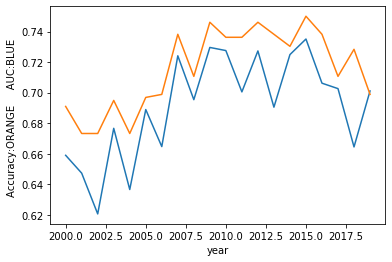

In [14]:
# 將各年AUC、Accuracy做折線圖

import matplotlib.pyplot as plt
plt.plot(year,auc_years)
plt.plot(year,accuracy_years)
plt.xlabel('year')
plt.ylabel('Accuracy:ORANGE     AUC:BLUE ')
plt.show

In [15]:
#正常場次(排名較高者獲勝之場次)
data_ATP[ATP_match_result==1]

,tourney_level,surface,tourney_year,tourney_date,player1,player2,result,rank1,rank2,rankpoint1,...,turn_pro_years_2,turn_pro_gap,age_gap_group,age_gap_ind,turn_pro_gap_ind,rankpoint_gap_group,player1_rating,player1_dev,player2_rating,player2_dev
0,G,Hard,2000,20000117,Andre Agassi,Mariano Puerta,1,1,112,4135,...,2,12,5~10,5~,5~,3600.0,1500.000000,350.000000,1337.787997,290.230506
1,G,Hard,2000,20000117,Sjeng Schalken,Galo Blanco,1,47,77,728,...,5,1,0~5,0~5,0~5,200.0,1601.772397,176.330339,1337.787997,290.230506
4,G,Hard,2000,20000117,Andrew Ilie,Jeff Tarango,1,46,65,732,...,11,-5,-10~-5,~ -5,-5~0,100.0,1391.114451,225.622846,1249.585995,256.270937
5,G,Hard,2000,20000117,Jiri Novak,Markus Hipfl,1,37,75,841,...,5,2,0~5,0~5,0~5,300.0,1391.114451,225.622846,1500.000000,350.000000
7,G,Hard,2000,20000117,Mark Philippoussis,Noam Okun,1,19,189,1258,...,4,2,0~5,0~5,0~5,1000.0,1500.000000,350.000000,1500.000000,350.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10153,G,Hard,2019,20190826,Daniil Medvedev,Stanislas Wawrinka,1,5,24,4125,...,17,-12,-15~-10,~ -5,~ -5,2500.0,1770.907207,49.969517,1685.744659,58.335253
10156,G,Hard,2019,20190826,Rafael Nadal,Diego Sebastian Schwartzman,1,2,21,7945,...,9,9,5~10,5~,5~,6100.0,2003.492755,61.852483,1651.450567,52.910096
10157,G,Hard,2019,20190826,Daniil Medvedev,Grigor Dimitrov,1,5,78,4125,...,11,-6,-5~0,-5~0,~ -5,3100.0,1770.907207,49.969517,1585.962463,62.236785
10158,G,Hard,2019,20190826,Rafael Nadal,Matteo Berrettini,1,2,25,7945,...,4,14,5~10,5~,5~,6100.0,2003.492755,61.852483,1655.834492,56.751581


In [16]:
#正常場次中Lightgbm預測成功場次
data_ATP[(ATP_match_result==1)&(pred_not_mw>0.5)]

,tourney_level,surface,tourney_year,tourney_date,player1,player2,result,rank1,rank2,rankpoint1,...,turn_pro_years_2,turn_pro_gap,age_gap_group,age_gap_ind,turn_pro_gap_ind,rankpoint_gap_group,player1_rating,player1_dev,player2_rating,player2_dev
0,G,Hard,2000,20000117,Andre Agassi,Mariano Puerta,1,1,112,4135,...,2,12,5~10,5~,5~,3600.0,1500.000000,350.000000,1337.787997,290.230506
1,G,Hard,2000,20000117,Sjeng Schalken,Galo Blanco,1,47,77,728,...,5,1,0~5,0~5,0~5,200.0,1601.772397,176.330339,1337.787997,290.230506
4,G,Hard,2000,20000117,Andrew Ilie,Jeff Tarango,1,46,65,732,...,11,-5,-10~-5,~ -5,-5~0,100.0,1391.114451,225.622846,1249.585995,256.270937
5,G,Hard,2000,20000117,Jiri Novak,Markus Hipfl,1,37,75,841,...,5,2,0~5,0~5,0~5,300.0,1391.114451,225.622846,1500.000000,350.000000
7,G,Hard,2000,20000117,Mark Philippoussis,Noam Okun,1,19,189,1258,...,4,2,0~5,0~5,0~5,1000.0,1500.000000,350.000000,1500.000000,350.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10153,G,Hard,2019,20190826,Daniil Medvedev,Stanislas Wawrinka,1,5,24,4125,...,17,-12,-15~-10,~ -5,~ -5,2500.0,1770.907207,49.969517,1685.744659,58.335253
10156,G,Hard,2019,20190826,Rafael Nadal,Diego Sebastian Schwartzman,1,2,21,7945,...,9,9,5~10,5~,5~,6100.0,2003.492755,61.852483,1651.450567,52.910096
10157,G,Hard,2019,20190826,Daniil Medvedev,Grigor Dimitrov,1,5,78,4125,...,11,-6,-5~0,-5~0,~ -5,3100.0,1770.907207,49.969517,1585.962463,62.236785
10158,G,Hard,2019,20190826,Rafael Nadal,Matteo Berrettini,1,2,25,7945,...,4,14,5~10,5~,5~,6100.0,2003.492755,61.852483,1655.834492,56.751581


In [17]:
#爆冷場次(排名較低者獲勝之場次)
data_ATP[ATP_match_result==0]

,tourney_level,surface,tourney_year,tourney_date,player1,player2,result,rank1,rank2,rankpoint1,...,turn_pro_years_2,turn_pro_gap,age_gap_group,age_gap_ind,turn_pro_gap_ind,rankpoint_gap_group,player1_rating,player1_dev,player2_rating,player2_dev
2,G,Hard,2000,20000117,Felix Mantilla,Mariano Zabaleta,0,27,33,1111,...,4,3,0~5,0~5,0~5,100.0,1208.238965,247.408423,1268.315986,286.846358
3,G,Hard,2000,20000117,Jan Siemerink,Todd Woodbridge,0,93,204,432,...,12,-1,0~5,0~5,-5~0,200.0,1337.787997,290.230506,1337.787997,290.230506
6,G,Hard,2000,20000117,Andrea Gaudenzi,Raemon Sluiter,0,88,166,440,...,4,6,0~5,0~5,5~,200.0,1500.000000,350.000000,1500.000000,350.000000
11,G,Hard,2000,20000117,Hernan Gumy,Andreas Vinciguerra,0,63,99,606,...,2,7,5~10,5~,5~,200.0,1500.000000,350.000000,1500.000000,253.345770
12,G,Hard,2000,20000117,Jacobo Diaz,Fredrik Jonsson,0,84,123,453,...,4,1,0~5,0~5,0~5,100.0,1270.109480,252.526941,1500.000000,253.345770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10145,G,Hard,2019,20190826,Novak Djokovic,Stanislas Wawrinka,0,1,24,11685,...,17,-1,-5~0,-5~0,-5~0,10100.0,1973.374353,61.517225,1685.744659,58.335253
10148,G,Hard,2019,20190826,Alex De Minaur,Grigor Dimitrov,0,38,78,1270,...,11,-7,-10~-5,~ -5,~ -5,500.0,1590.892610,57.897066,1585.962463,62.236785
10151,G,Hard,2019,20190826,Alexander Zverev,Diego Sebastian Schwartzman,0,6,21,4005,...,9,-3,-5~0,-5~0,-5~0,2200.0,1711.243713,55.220555,1651.450567,52.910096
10154,G,Hard,2019,20190826,Roger Federer,Grigor Dimitrov,0,3,78,6950,...,11,10,5~10,5~,5~,6100.0,1969.098592,62.578366,1585.962463,62.236785


In [18]:
#爆冷門場次中Lightgbm預測成功場次
data_ATP[(ATP_match_result==0)&(pred_not_mw<0.5)]

,tourney_level,surface,tourney_year,tourney_date,player1,player2,result,rank1,rank2,rankpoint1,...,turn_pro_years_2,turn_pro_gap,age_gap_group,age_gap_ind,turn_pro_gap_ind,rankpoint_gap_group,player1_rating,player1_dev,player2_rating,player2_dev
129,G,Clay,2000,20000529,Alberto Berasategui,Jiri Vanek,0,83,88,494,...,5,4,0~5,0~5,0~5,0.0,1223.454763,133.204432,1549.227954,136.431837
154,G,Clay,2000,20000529,Marcelo Rios,Tommy Haas,0,19,21,1275,...,4,2,0~5,0~5,0~5,0.0,1561.326123,83.181869,1594.775989,90.126402
216,G,Clay,2000,20000529,Orlin Stanoytchev,Michel Kratochvil,0,104,120,388,...,3,4,5~10,5~,0~5,0.0,1319.976721,104.880206,1512.015155,180.518862
242,G,Clay,2000,20000529,Cedric Pioline,Marat Safin,0,6,12,2219,...,3,8,10~15,5~,5~,400.0,1762.060545,86.631184,1739.871050,79.909121
298,G,Grass,2000,20000626,Ronald Agenor,Alexander Popp,0,98,114,408,...,3,14,10~15,5~,5~,0.0,1331.498826,107.325148,1316.148262,170.016500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,G,Grass,2019,20190701,Dusan Lajovic,Hubert Hurkacz,0,36,48,1251,...,4,8,5~10,5~,5~,200.0,1548.315435,58.703254,1542.642922,70.058498
10034,G,Hard,2019,20190826,Sam Querrey,Juan Ignacio Londero,0,46,56,1055,...,9,4,5~10,5~,0~5,0.0,1627.836294,60.092457,1567.152156,69.973549
10067,G,Hard,2019,20190826,Leonardo Mayer,Antonie Hoang,0,95,104,555,...,3,13,5~10,5~,5~,0.0,1520.698327,58.065521,1483.668176,135.728638
10070,G,Hard,2019,20190826,Joao Sousa,Jordan Thompson,0,44,55,1061,...,6,5,5~10,5~,5~,0.0,1512.098272,56.318803,1504.893171,60.092255


### 變數重要性

In [19]:
feature_importance=pd.DataFrame({'feature':features,
                                 'feature_importance':gbm.feature_importance()})
feature_importance

,feature,feature_importance
0,rank1,0
1,rankpoint1,4
2,rank2,11
3,rankpoint2,5
4,age1,6
5,age2,5
6,turn_pro_years_1,0
7,turn_pro_years_2,0
8,hand1,0
9,hand2,0


## 以靜態變數訓練Lightgbm Model (4:2 年 Moving Windows)

### 訓練模型

In [20]:
import lightgbm as lgb
#決定模型參數
parameter={
    'seed': 2020,
    'boosting_type': 'gbdt',  # 設置梯度提升樹
    'objective': 'binary', # 
    'metric': ['auc'],  # 評估準則
    'max_depth':5, #控制建樹深度
    'num_leaves': 5,   # 葉子節點數
    'learning_rate': 0.01,  # 學習率
    'feature_fraction': 0.9, # 建樹的特徵選擇比例
    'bagging_fraction': 0.5, # 建樹的樣本採樣比例
    'bagging_freq': 5,  # 
    'verbose': 0 # 顯示訓練過程
    }

In [21]:
pred=[]
pred_valid=[]

for k in range(16, 72+1, 4):
    train_period=((ATP_match_data['period']> k-16)&(ATP_match_data['period']<=k))
    test_period=((ATP_match_data['period']>k)&(ATP_match_data['period']<= k+8))
      
    Train=lgb.Dataset(ATP_match_data[train_period][features], label=ATP_match_result[train_period],
                      categorical_feature=['hand1','hand2'])
    

    gbm=lgb.train(parameter,Train,num_boost_round=100)
    
    pre_k=gbm.predict(ATP_match_data[test_period][features])/(gbm.predict(ATP_match_data[test_period][features])+gbm.predict(ATP_match_data_mirror[test_period][features]))
    
    if len(pred)!=0:
        pred[len(pred)-508:len(pred)]=(pred[len(pred)-508:len(pred)]+pre_k[0:508])/2
        
        #extend與append相似，但若函數內物件為list，會將元素一個一個加入到目標物件
        pred.extend(pre_k[508:1016].tolist())
    else:
        pred.extend(pre_k.tolist())
     
    #追加train_data的預測，以比較train_data與test_data預測成效的差異
    pre_valid_k=gbm.predict(ATP_match_data[train_period][features])/(gbm.predict(ATP_match_data[train_period][features])+gbm.predict(ATP_match_data_mirror[train_period][features]))
    if len(pred_valid)!=0:
        pred_valid[len(pred_valid)-1524:len(pred_valid)]=(pred_valid[len(pred_valid)-1524:len(pred_valid)]+pre_valid_k[0:1524])/2
        
        #extend與append相似，但若函數內物件為list，會將元素一個一個加入到目標物件
        pred_valid.extend(pre_valid_k[1524:2032].tolist())
    else:
        pred_valid.extend(pre_valid_k.tolist())

### 預測成效

In [22]:
# Moving Windows 4:2年平均預測Accuracy、AUC

from sklearn.metrics import roc_auc_score,accuracy_score

auc=roc_auc_score(ATP_match_result[ATP_match_data['period']>16],pred)
accuracy=accuracy_score(ATP_match_result[ATP_match_data['period']>16],(np.array(pred)>0.5).astype(int))
print('Accuracy_of_ATP_Moving Windows ={}'.format(accuracy))
print('AUC_of_ATP_Moving Windows ={}'.format(auc))

Accuracy_of_ATP_Moving Windows =0.7209645669291339
AUC_of_ATP_Moving Windows =0.6899034962150621


In [23]:
# 每期 Moving Windows會拿前4年 Train_dataset，後2年為Test_dataset
#從2000年至2017年，共18年的訓練資料平均的Accuracy、AUC
valid_period=ATP_match_data['period']<=72
auc=roc_auc_score(ATP_match_result[valid_period],pred_valid)
accuracy=accuracy_score(ATP_match_result[valid_period],(np.array(pred_valid)>0.5).astype(int))
print('Accuracy_of_ATP_Moving Windows ={}'.format(accuracy))
print('AUC_of_ATP_Moving Windows ={}'.format(auc))

Accuracy_of_ATP_Moving Windows =0.7311898512685914
AUC_of_ATP_Moving Windows =0.722290162531573


In [24]:
# 將各年AUC、Accuracy串成list

from sklearn.metrics import accuracy_score,roc_auc_score 

year=[year for year in range(2004,2020)]
auc_years=[]
accuracy_years=[]
for k in range(1,16+1):
    #result_period=((ATP_match_data['period']>k)&(ATP_match_data['period']<= k+4))
    #predict_period=((ATP_match_data['period']> k-16)&(ATP_match_data['period']<=k-12))
    #一年508場，前四年無預測資料，
    auc_k=roc_auc_score(ATP_match_result[(k-1)*508+2032:k*508+2032],pred[(k-1)*508:k*508])
    accuracy_k=accuracy_score(ATP_match_result[(k-1)*508+2032:k*508+2032],(np.array(pred[(k-1)*508:k*508])>0.5).astype(int))
    auc_years.append(auc_k)
    accuracy_years.append(accuracy_k)

<function matplotlib.pyplot.show(*args, **kw)>

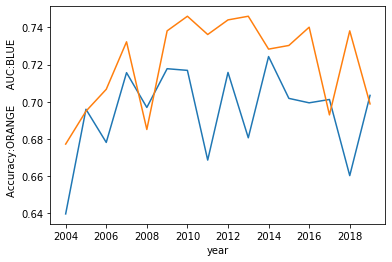

In [25]:
# 將各年AUC、Accuracy做折線圖

import matplotlib.pyplot as plt
plt.plot(year,auc_years)
plt.plot(year,accuracy_years)
plt.xlabel('year')
plt.ylabel('Accuracy:ORANGE     AUC:BLUE ')
plt.show

### 變數重要性

In [26]:
feature_importance=pd.DataFrame({'feature':features,
                                 'feature_importance':gbm.feature_importance()})
feature_importance

,feature,feature_importance
0,rank1,16
1,rankpoint1,39
2,rank2,18
3,rankpoint2,9
4,age1,14
5,age2,9
6,turn_pro_years_1,17
7,turn_pro_years_2,2
8,hand1,1
9,hand2,1


### 特殊條件下模型成效

In [27]:
#將有測到的比賽先抓出來
ATP_Match_Valid=data_ATP[data_ATP['period']>16]
ATP_Match_Valid['prediction']=pred
#1.排名前10名v.s.其他
#抓出比賽至少其中一名參賽者在10名以內的預測力
#比對比賽兩名參賽者皆在10名以外的預測力



#先做有排名前10
from sklearn.metrics import roc_auc_score,accuracy_score
auc=roc_auc_score(ATP_Match_Valid[(ATP_Match_Valid['rank1']<=10)|(ATP_Match_Valid['rank2']<=10)]['result'],
                 ATP_Match_Valid[(ATP_Match_Valid['rank1']<=10)|(ATP_Match_Valid['rank2']<=10)]['prediction'])
accuracy=accuracy_score(ATP_Match_Valid[(ATP_Match_Valid['rank1']<=10)|(ATP_Match_Valid['rank2']<=10)]['result'],
                        (np.array(ATP_Match_Valid[(ATP_Match_Valid['rank1']<=10)|(ATP_Match_Valid['rank2']<=10)]['prediction'])>0.5).astype(int))
print('Valid_Match_Rank_Within_10 ={}'.format(ATP_Match_Valid[(ATP_Match_Valid['rank1']<=10)|(ATP_Match_Valid['rank2']<=10)].shape[0]))
print('Accuracy_of_ATP_Lightgbm_Rank_Within_10 ={}'.format(accuracy))
print('AUC_of_ATP_Lightgbm_Rank_Within_10 ={}'.format(auc))

Valid_Match_Rank_Within_10 =2425
Accuracy_of_ATP_Lightgbm_Rank_Within_10 =0.8494845360824742
AUC_of_ATP_Lightgbm_Rank_Within_10 =0.6911541565778854


In [28]:
#再做排名前10外
from sklearn.metrics import roc_auc_score,accuracy_score
auc=roc_auc_score(ATP_Match_Valid[(ATP_Match_Valid['rank1']>10)&(ATP_Match_Valid['rank2']>10)]['result'],
                 ATP_Match_Valid[(ATP_Match_Valid['rank1']>10)&(ATP_Match_Valid['rank2']>10)]['prediction'])
accuracy=accuracy_score(ATP_Match_Valid[(ATP_Match_Valid['rank1']>10)&(ATP_Match_Valid['rank2']>10)]['result'],
                        (np.array(ATP_Match_Valid[(ATP_Match_Valid['rank1']>10)&(ATP_Match_Valid['rank2']>10)]['prediction'])>0.5).astype(int))
print('Valid_Match_Rank_OutOf_10 ={}'.format(ATP_Match_Valid[(ATP_Match_Valid['rank1']>10)&(ATP_Match_Valid['rank2']>10)].shape[0]))
print('Accuracy_of_ATP_Lightgbm_Rank_OutOf_10 ={}'.format(accuracy))
print('AUC_of_ATP_Lightgbm_Rank_OutOf_10 ={}'.format(auc))

Valid_Match_Rank_OutOf_10 =5703
Accuracy_of_ATP_Lightgbm_Rank_OutOf_10 =0.6663159740487463
AUC_of_ATP_Lightgbm_Rank_OutOf_10 =0.6409918132690713


In [29]:
#2.排名差10名以內 v.s.其他
#抓出比賽兩名參賽者排名差<=10的預測力
#比對比賽兩名參賽者排名差>10的預測力


#先做排名差<=10
from sklearn.metrics import roc_auc_score,accuracy_score
auc=roc_auc_score(ATP_Match_Valid[abs(ATP_Match_Valid['rankgap'])<=10]['result'],
                 ATP_Match_Valid[abs(ATP_Match_Valid['rankgap'])<=10]['prediction'])
accuracy=accuracy_score(ATP_Match_Valid[abs(ATP_Match_Valid['rankgap'])<=10]['result'],
                        (np.array(ATP_Match_Valid[abs(ATP_Match_Valid['rankgap'])<=10]['prediction'])>0.5).astype(int))
print('Valid_Match_RankGap_Within_10 ={}'.format(ATP_Match_Valid[abs(ATP_Match_Valid['rankgap'])<=10].shape[0]))
print('Accuracy_of_ATP_Lightgbm_RankGap_Within_10 ={}'.format(accuracy))
print('AUC_of_ATP_Lightgbm_RankGap_Within_10 ={}'.format(auc))

Valid_Match_RankGap_Within_10 =1009
Accuracy_of_ATP_Lightgbm_RankGap_Within_10 =0.5649157581764123
AUC_of_ATP_Lightgbm_RankGap_Within_10 =0.5757156103854217


In [30]:
#再做排名差>10
from sklearn.metrics import roc_auc_score,accuracy_score
auc=roc_auc_score(ATP_Match_Valid[abs(ATP_Match_Valid['rankgap'])>10]['result'],
                 ATP_Match_Valid[abs(ATP_Match_Valid['rankgap'])>10]['prediction'])
accuracy=accuracy_score(ATP_Match_Valid[abs(ATP_Match_Valid['rankgap'])>10]['result'],
                        (np.array(ATP_Match_Valid[abs(ATP_Match_Valid['rankgap'])>10]['prediction'])>0.5).astype(int))
print('Valid_Match_RankGap_Within_10 ={}'.format(ATP_Match_Valid[abs(ATP_Match_Valid['rankgap'])>10].shape[0]))
print('Accuracy_of_ATP_Lightgbm_RankGap_Within_10 ={}'.format(accuracy))
print('AUC_of_ATP_Lightgbm_RankGap_Within_10 ={}'.format(auc))

Valid_Match_RankGap_Within_10 =7119
Accuracy_of_ATP_Lightgbm_RankGap_Within_10 =0.7430818935243714
AUC_of_ATP_Lightgbm_RankGap_Within_10 =0.6905226116710597
